In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import polars as pl
import fastai.vision.all as fv
import numpy as np
import torch

# Enable TFloat
torch.set_float32_matmul_precision('high')

from torch.utils.data import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

from einops.layers.torch import Rearrange, Reduce
from einops import rearrange
from torchvision.ops import Permute
import torch.nn.functional as F
from typing import Callable, Optional
from torch import nn, Tensor
from torch.nn import functional as F
from functools import partial

from arch import Net, NetTr, NetMLP

/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#test_df = pl.read_csv('/mnt/ssd/kaggle/test.csv')
weightings = pd.read_csv('/mnt/ssd/kaggle/sample_submission.csv', nrows=1)
#train_df = pl.read_csv('/mnt/ssd/kaggle/train.csv', n_rows=1_000_000, n_threads=10) # dtypes=[pl.datatypes.String] + [pl.Float32]*924

In [4]:
weights = weightings.iloc[0, 1:].values.astype(np.float32)

In [5]:
#train_df.write_parquet('/mnt/ssd/kaggle/train3.parquet')
#test_df.write_parquet('/mnt/ssd/kaggle/test.parquet')
#test_df = pl.read_parquet('/mnt/ssd/kaggle/test.parquet')
train_df = pl.read_parquet('/mnt/ssd/kaggle/train2.parquet')

In [6]:
pl.Config(tbl_cols=-1)
train_df = pl.read_parquet('/mnt/ssd/kaggle/train2.parquet')

NUM_VERT = 60
NUM_VERT_FEAT = 9
NUM_VERT_FEAT_Y = 6

FEAT_COLS = train_df.columns[1:557]
TARGET_COLS= train_df.columns[557:]


NUM_2D_FEAT = len(FEAT_COLS) - NUM_VERT*NUM_VERT_FEAT
NUM_2D_FEAT_Y = len(TARGET_COLS) - NUM_VERT*NUM_VERT_FEAT_Y

# Predict a multiplier of q for q_tends
FRAC_IDXS = (NUM_VERT, NUM_VERT*4)

NUM_2D_FEAT, NUM_2D_FEAT_Y

(16, 8)

In [7]:
NUM_GRID_CELLS = 384
emb_idxs = np.arange(len(train_df), dtype=np.int64) % NUM_GRID_CELLS

In [8]:
x_train = train_df.select(FEAT_COLS).to_numpy()
y_train = train_df.select(TARGET_COLS).to_numpy()*weights[None, :]

x_train, x_val, emb_train, emb_val, y_train, y_val = train_test_split(x_train, emb_idxs, y_train, test_size=0.05, random_state=42)

In [9]:
#x_test = test_df.select(FEAT_COLS).to_numpy()

In [10]:
# import gc
# del train_df
# gc.collect()

In [11]:
std_weights = 1.0/(weights)
std_weights[weights == 0] = 0
assert np.isfinite(std_weights).all()

/tmp/ipykernel_3983526/2352397551.py:1: RuntimeWarning: divide by zero encountered in divide
  std_weights = 1.0/(weights)


In [12]:
1/weights.max()

1.0000000130088962e-15

In [13]:
import json

class Norm():
    def __init__(self, fname=None, stds=None, means=None, zero_mask=None, dataset=None, eps=1e-14):
        if dataset is not None:        
            self.means, self.stds = np.mean(dataset, axis=0), np.std(dataset, axis=0)
            with open(fname, 'w') as f:
                f.write(json.dumps({'means' : self.means.tolist(), 'stds' : self.stds.tolist()}))
        elif means is not None and stds is not None:
            self.stds = stds.copy()
            self.means = means.copy()
        else:
            with open(fname) as f:
                stats_dict = json.loads(f.read())
                
            self.means = np.asarray(stats_dict['means'])
            self.stds = np.asarray(stats_dict['stds'])
            
        self.means = self.means[None, :]
        self.stds = self.stds[None, :]

        self.zero_mask = self.stds[0] <= eps if zero_mask is None else zero_mask
         
        self.stds[:, self.zero_mask] = 1.0
        
        self.eps = eps
        #self.df = pd.DataFrame({'col' : names, 'std' : self.stds, 'mean' : self.means})
        
    def __call__(self, data):
        out = (data - self.means) / self.stds
        out[:, self.zero_mask] = 0
        
        return out.astype(np.float32)
        
    def denorm(self, data):
        data = data.astype(np.float64)
        out = data * self.stds + self.means 
        
        out[:, self.zero_mask] = 0#self.means[:, self.zero_mask]
        return out


In [14]:
y_val.shape

(200000, 368)

In [15]:
std_weights.shape

(368,)

In [16]:
std_weights

array([3.22775704e-05, 4.44396428e-05, 5.29264435e-05, 6.88978325e-05,
       9.13713666e-05, 1.10314264e-04, 1.03480364e-04, 7.88111647e-05,
       5.02760849e-05, 3.87126165e-05, 2.95069094e-05, 2.26639477e-05,
       1.67192611e-05, 1.25890556e-05, 9.31455907e-06, 7.36806487e-06,
       6.69344763e-06, 7.78252797e-06, 1.08996301e-05, 1.37459374e-05,
       1.50304659e-05, 1.58900893e-05, 1.76646390e-05, 2.02129868e-05,
       2.32400416e-05, 2.70909641e-05, 3.17592094e-05, 3.71773858e-05,
       4.28878302e-05, 4.88764999e-05, 5.43901442e-05, 5.84405570e-05,
       6.12077129e-05, 6.30606082e-05, 6.41811348e-05, 6.45261607e-05,
       6.40522412e-05, 6.32996162e-05, 6.26008696e-05, 6.19947605e-05,
       6.14956589e-05, 6.10802963e-05, 6.09866947e-05, 6.12540025e-05,
       6.16194520e-05, 6.17596161e-05, 6.11949872e-05, 6.00755338e-05,
       5.88045259e-05, 5.73713623e-05, 5.58433348e-05, 5.42547896e-05,
       5.25417854e-05, 5.07579280e-05, 4.89998238e-05, 4.76935238e-05,
      

In [17]:
x_train.shape

(3800000, 556)

In [18]:
# y = y_train*weights[None, :]
# my = y.mean(axis=0)
# sy = (y*y).mean(axis=0)
# sy[sy < 1e-14] = 1e-14

In [19]:
 # with open('stats_y_squared.json', 'w') as f:
 #    f.write(json.dumps({'means' : my.tolist(), 'stds' : sy.tolist()}))

In [20]:
norm_x = Norm(fname='x_stats8.json', eps=1e-7)
# Set means to zero for q vars so we can predict a multipler
norm_x.means[:, FRAC_IDXS[0]:FRAC_IDXS[1]] = 0.0

norm_y = Norm(stds=np.ones(y_train.shape[1]), means=np.zeros_like(std_weights), zero_mask=std_weights<1e-13)# dataset=y_train)
# This variable still seems to have norm issues.
indxs = [TARGET_COLS.index(a) for a  in ['ptend_q0002_26', 'ptend_q0002_25']]
col = "ptend_q0002_26"
norm_y.zero_mask[indxs] = True

In [21]:
# This variable still seems to have norm issues.
indxs = [TARGET_COLS.index(a) for a  in ['ptend_q0002_26', 'ptend_q0002_25']]
col = "ptend_q0002_26"
norm_y.zero_mask[indxs] = True


In [22]:
# y_t = norm_y(y_train[0:1000])

In [23]:
# pred_norm = norm_x(x_train[0:1000])

In [24]:
# pred_norm.max(), pred_norm.std()

In [25]:
# pred = norm_y.denorm(y_t)

In [26]:
# (y_train[0:1000] - pred).max()

In [27]:
class Loader(Dataset):
    def __init__(self, data_dict, norm_dict):
        self.data_dict = data_dict
        self.norm_dict = norm_dict
        
    def __getitem__(self, idx):
        x = self.data_dict['x'][idx].copy()
        y = self.data_dict['y'][idx].copy() if 'y' in self.data_dict else np.zeros(1)
        x = self.norm_dict['x'](x[None, :])[0]
        y = self.norm_dict['y'](y[None, :])[0] if 'y' in self.data_dict else np.zeros(1)
        emb_idx = self.data_dict['emb'][idx]
        return (x.astype(np.float32), emb_idx), y.astype(np.float32)
    
    def __len__(self,):
        return self.data_dict['x'].shape[0]

In [28]:
len(emb_train), len(emb_val)

(3800000, 200000)

In [29]:
train_ds = Loader({'x' : x_train, 'y' : y_train, 'emb' : emb_train}, {'x' : norm_x, 'y' : norm_y})
val_ds = Loader({'x' : x_val, 'y' : y_val, 'emb' : emb_val}, {'x' : norm_x, 'y' : norm_y})

In [30]:
len(train_ds), len(val_ds), #len(x_test)

(3800000, 200000)

In [35]:
from random import shuffle


bs = 128
train_loader = fv.DataLoader(train_ds, batch_size=bs, drop_last=True, 
                          shuffle=True, num_workers=0, pin_memory=False)
valid_loader = fv.DataLoader(val_ds, batch_size=bs, drop_last=True,
                             shuffle=False, num_workers=0, pin_memory=False)


In [36]:
# batch = next(iter(train_loader))
# x = batch[0]
# y = batch[1]
# x[0].mean(), x[0].std(), y.mean(), y.std(), x[0].min(), x[0].max(), y.min(), y.max()

In [37]:
#x[0][:, FRAC_IDXS[0]:FRAC_IDXS[1]].mean(dim=0)

In [38]:
#net = torch.compile(net)
dls = fv.DataLoaders(train_loader, valid_loader).to('cuda')

In [78]:
net = Net(NUM_2D_FEAT, NUM_VERT_FEAT, NUM_2D_FEAT_Y, NUM_VERT_FEAT_Y, frac_idxs=None, 
          dim=512, depth=8)
#net(batch[0])



In [79]:
net = torch.compile(net)

In [80]:
def l1_loss(pred, tar):
    diff = torch.abs(tar - pred)
    return diff.mean()

In [60]:
s_total = np.mean((y_val - y_val.mean())**2)

In [61]:
s_total

0.88578206

In [62]:
#s_total

In [81]:
def mse(pred, tar):
    diff = tar - pred
    return ((diff)**2).mean()

def r_squared(pred, tar, mask=None):
    # tar = norm_y.denorm(tar.cpu().numpy())
    # pred = norm_y.denorm(pred.detach().cpu().numpy())
    #pred = pred*weights[None, :]
    #tar = tar*weights[None, :]
    # mask = ~norm_y.zero_mask
    # if mask is not None:
    #     tar = tar[:, mask]
    #     pred = pred[:, mask]
    #tar_m = norm_y.means[:, mask]
    return 1 - (torch.mean((tar - pred)**2) / s_total)
    

In [82]:
#net.load_state_dict(temp_data['model'])#.keys()

In [83]:
learn = fv.Learner(dls, net, loss_func=nn.HuberLoss(delta=10.0), metrics=[fv.mae, fv.mse, r_squared], #nn.HuberLoss(delta=2.0)
                   wd=0.001, opt_func=fv.ranger, cbs=[fv.SaveModelCallback(monitor='r_squared', comp=np.greater,)
                                                      , fv.GradientClip()]).to_fp16()#.load('model_temp') #fv.SaveModelCallback(monitor='r_squared', comp=np.greater,)

In [84]:
learn.summary()

W0512 10:07:27.839000 130080114145088 torch/_dynamo/convert_frame.py:357] torch._dynamo hit config.cache_size_limit (8)
W0512 10:07:27.839000 130080114145088 torch/_dynamo/convert_frame.py:357]    function: 'hook_fn' (/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/fastai/callback/hook.py:21)
W0512 10:07:27.839000 130080114145088 torch/_dynamo/convert_frame.py:357]    last reason: ___check_type_id(L['module'], 97391516797472)               
W0512 10:07:27.839000 130080114145088 torch/_dynamo/convert_frame.py:357] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0512 10:07:27.839000 130080114145088 torch/_dynamo/convert_frame.py:357] To diagnose recompilation issues, see https://pytorch.org/docs/master/compile/troubleshooting.html.
W0512 10:07:29.842000 130080114145088 torch/_dynamo/convert_frame.py:357] torch._dynamo hit config.cache_size_limit (8)
W0512 10:07:29.842000 130080114145088 torch/_dynamo/convert_frame.py:357]    function: 'to_detach' (/home/leroy/c

OptimizedModule (Input shape: 128 x torch.Size([128]))
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 960 x 1       
Conv1d                                    1920       True      
____________________________________________________________________________
                     128 x 16 x 60       
Rearrange                                                      
____________________________________________________________________________
                     128 x 9 x 60        
Rearrange                                                      
____________________________________________________________________________
                     128 x 496 x 60      
Conv1d                                    4960       True      
Identity                                                       
Conv1d                                    4096       True      
LayerNorm                                 1024       True      
__________________________________

Exception ignored in: <function ExactWeakKeyDictionary.__setitem__.<locals>.<lambda> at 0x763e22ab7370>
Traceback (most recent call last):
  File "/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/_dynamo/utils.py", line 469, in <lambda>
    self.refs[idx] = weakref.ref(key, lambda ref: self._remove_id(idx))
  File "/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/_dynamo/utils.py", line 716, in _remove_id
    hook()
  File "/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/_dynamo/utils.py", line 700, in __call__
    del self.scope[self.name]
KeyError: '__compiled_fn_4'
Exception ignored in: <function ExactWeakKeyDictionary.__setitem__.<locals>.<lambda> at 0x763e22d2b400>
Traceback (most recent call last):
  File "/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/_dynamo/utils.py", line 469, in <lambda>
    self.refs[idx] = weakref.ref(key, lambda ref: self._remove_id(idx))
  File "/home/leroy/conda/envs/torch2/lib/python3.1

SuggestedLRs(valley=0.0005207948270253837)

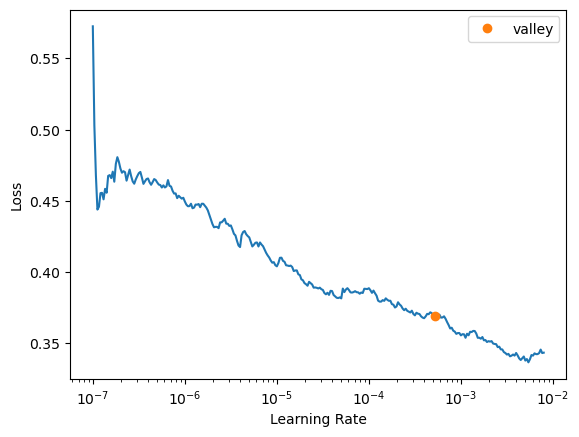

In [85]:
learn.lr_find(num_it=300, end_lr=1e-2)

SuggestedLRs(valley=0.00022387212084140629)

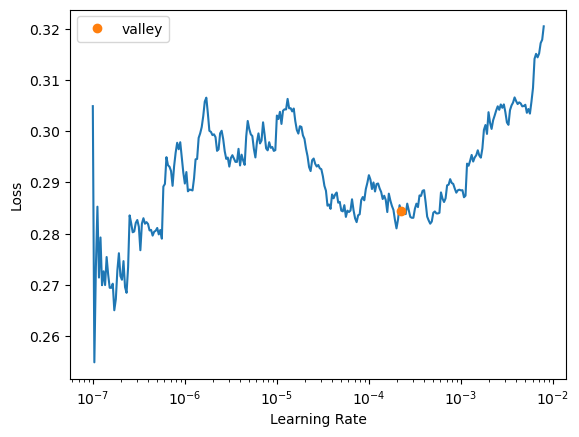

In [58]:
learn.lr_find(num_it=300, end_lr=1e-2)

In [47]:
learn.fit(2, 1e-4, wd=0.01)

epoch,train_loss,valid_loss,mae,mse,r_squared,time


KeyboardInterrupt: 

In [86]:
learn.fit_flat_cos(15, 1e-3, wd=0.01)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.138223,0.140573,0.188750,0.332497,0.624629,24:08
1,0.130847,0.131487,0.180172,0.307260,0.653119,23:43
2,0.137762,0.130025,0.181967,0.298409,0.663113,23:41
3,0.123283,0.128005,0.177962,0.291168,0.671286,23:45
4,0.125265,0.125230,0.174869,0.283553,0.679884,23:47
5,0.122154,0.125402,0.173913,0.283285,0.680187,23:47
6,0.125074,0.122887,0.172365,0.277708,0.686483,23:49
7,0.120514,0.123744,0.172361,0.281915,0.681733,23:47
8,0.123021,0.123361,0.171541,0.281699,0.681976,23:42
9,0.121947,0.123491,0.172979,0.278708,0.685353,23:46


/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
/home/leroy/conda/e

Better model found at epoch 0 with r_squared value: 0.6246293783187866.
Better model found at epoch 1 with r_squared value: 0.6531193256378174.
Better model found at epoch 2 with r_squared value: 0.6631125807762146.
Better model found at epoch 3 with r_squared value: 0.6712861657142639.
Better model found at epoch 4 with r_squared value: 0.6798838376998901.
Better model found at epoch 5 with r_squared value: 0.6801873445510864.
Better model found at epoch 6 with r_squared value: 0.6864829063415527.
Better model found at epoch 10 with r_squared value: 0.6873109340667725.
Better model found at epoch 11 with r_squared value: 0.6892145872116089.
Better model found at epoch 12 with r_squared value: 0.6995758414268494.
Better model found at epoch 13 with r_squared value: 0.7090945839881897.
Better model found at epoch 14 with r_squared value: 0.7101508975028992.


In [76]:
learn.fit_flat_cos(10, 1e-4, wd=0.01)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.113439,0.120215,0.169136,0.279328,0.684654,1:06:30
1,0.118187,0.119444,0.168678,0.276340,0.688027,1:06:35
2,0.111758,0.118573,0.167167,0.274120,0.690534,1:06:33
3,0.112457,0.118272,0.166766,0.273213,0.691557,1:06:34
4,0.116703,0.118066,0.166885,0.271521,0.693467,1:06:29
5,0.113750,0.118373,0.166376,0.270759,0.694328,1:06:26
6,0.109780,0.118197,0.166344,0.270284,0.694864,1:06:28
7,0.108059,0.118051,0.165657,0.269603,0.695633,1:06:30
8,0.104679,0.117424,0.164565,0.267892,0.697564,1:06:36
9,0.104519,0.117578,0.164313,0.268119,0.697308,1:06:28


Better model found at epoch 0 with r_squared value: 0.6846542954444885.
Better model found at epoch 1 with r_squared value: 0.6880269050598145.
Better model found at epoch 2 with r_squared value: 0.6905336976051331.
Better model found at epoch 3 with r_squared value: 0.6915570497512817.
Better model found at epoch 4 with r_squared value: 0.6934674382209778.
Better model found at epoch 5 with r_squared value: 0.6943279504776001.
Better model found at epoch 6 with r_squared value: 0.6948638558387756.
Better model found at epoch 7 with r_squared value: 0.6956329345703125.
Better model found at epoch 8 with r_squared value: 0.6975640654563904.


In [62]:
#del learn, 
del net

In [63]:
import gc
gc.collect()

68757

In [62]:
learn.save('model_temp')

Path('models/model_temp.pth')

In [65]:
learn.validate()

(#4) [0.10548990964889526,0.1505843549966812,0.25680434703826904,0.7100826501846313]

In [ ]:
learn.fit_flat_cos(12, 2e-4, wd=0.01)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.132663,0.123431,0.170884,0.308618,0.651587,3:58:53
1,0.116149,0.119035,0.170044,0.295035,0.666922,3:58:58
2,0.122057,0.117260,0.164114,0.290335,0.672227,3:58:56
3,0.115437,0.114895,0.169516,0.282178,0.681435,3:58:34
4,0.116658,0.111350,0.157978,0.272206,0.692694,3:58:37


/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
/home/leroy/conda/e

Better model found at epoch 0 with r_squared value: 0.6515868902206421.
Better model found at epoch 1 with r_squared value: 0.6669217944145203.
Better model found at epoch 2 with r_squared value: 0.6722266674041748.
Better model found at epoch 3 with r_squared value: 0.6814352869987488.
Better model found at epoch 4 with r_squared value: 0.6926941275596619.


In [191]:
learn.loss_func = l1_loss

In [45]:
learn.fit_flat_cos(6, 1e-4, wd=0.01)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.105264,0.111163,0.160486,0.281360,0.716221,52:37
1,0.102502,0.111544,0.159997,0.286838,0.715084,52:21
2,0.100816,0.112530,0.161047,0.277096,0.712049,52:23
3,0.100829,0.112151,0.160246,0.276400,0.713291,52:23
4,0.102632,0.111182,0.159459,0.279898,0.716126,52:24
5,0.094074,0.108079,0.152991,0.262921,0.725166,52:25


/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
/home/leroy/conda/e

Better model found at epoch 0 with r_squared value: 0.7162206768989563.
Better model found at epoch 5 with r_squared value: 0.7251663208007812.


In [52]:
learn.validate()

/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


IndexError: Exception occured in `SaveModelCallback` when calling event `after_epoch`:
	list index out of range

In [69]:
learn.fit(3, 1e-3, wd=0.01)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.145379,0.136719,0.195003,0.342077,0.650307,1:11:58
1,0.125336,0.126382,0.184133,0.314350,0.679277,1:11:40
2,0.126290,0.123718,0.179871,0.308917,0.686294,1:11:40


/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
/home/leroy/conda/e

Better model found at epoch 0 with r_squared value: 0.6503068208694458.
Better model found at epoch 1 with r_squared value: 0.6792766451835632.
Better model found at epoch 2 with r_squared value: 0.6862936615943909.


In [70]:
learn.fit_flat_cos(7, 4e-4)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.100010,0.113239,0.166109,0.277009,0.715268,1:11:53
1,0.118272,0.112384,0.165332,0.274715,0.717663,1:11:53
2,0.108533,0.111935,0.165136,0.272125,0.718529,1:11:50
3,0.102703,0.110852,0.164110,0.270032,0.721469,1:11:49
4,0.103124,0.110735,0.163129,0.266873,0.722130,1:11:50
5,0.106697,0.108933,0.159765,0.263053,0.726570,1:11:53
6,0.092933,0.105747,0.154466,0.253241,0.735189,1:11:50


Better model found at epoch 0 with r_squared value: 0.7152675986289978.
Better model found at epoch 1 with r_squared value: 0.7176631093025208.
Better model found at epoch 2 with r_squared value: 0.718529224395752.
Better model found at epoch 3 with r_squared value: 0.7214685678482056.
Better model found at epoch 4 with r_squared value: 0.7221300601959229.
Better model found at epoch 5 with r_squared value: 0.7265703678131104.
Better model found at epoch 6 with r_squared value: 0.7351890802383423.


In [193]:
learn.loss_func = mse

In [71]:
learn.save('tr_v1')

Path('models/tr_v1.pth')

In [131]:
learn.validate()

IndexError: Exception occured in `SaveModelCallback` when calling event `after_epoch`:
	list index out of range

In [ ]:
learn.fit_flat_cos(14, 1e-3)


epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.264858,0.288008,0.174881,0.288008,0.690495,19:53
1,0.259229,0.278898,0.169802,0.278898,0.698412,19:54
2,0.242027,0.269742,0.169581,0.269742,0.706795,19:54
3,0.235599,0.267588,0.169591,0.267588,0.708273,19:56
4,0.242983,0.267330,0.169089,0.267330,0.709385,19:56
5,0.232772,0.265025,0.169060,0.265025,0.709853,19:58
6,0.351062,0.265223,0.170867,0.265223,0.708562,19:57
7,0.227057,0.265318,0.170030,0.265318,0.709494,19:58
8,0.223291,0.269968,0.170160,0.269968,0.708803,19:57
9,0.219373,0.266356,0.169020,0.266356,0.709530,19:56


Better model found at epoch 0 with r_squared value: 0.6904946366345599.
Better model found at epoch 1 with r_squared value: 0.6984116024016455.
Better model found at epoch 2 with r_squared value: 0.7067945812816843.
Better model found at epoch 3 with r_squared value: 0.7082729521368367.
Better model found at epoch 4 with r_squared value: 0.7093854982283825.
Better model found at epoch 5 with r_squared value: 0.7098527482682689.


In [93]:
learn.fit(10, 2e-4)


epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.312845,0.348528,0.186559,0.348528,0.646830,47:49
1,0.295979,0.386613,0.175216,0.386613,0.669071,47:50
2,0.312540,0.316801,0.172706,0.316801,0.684723,47:49
3,0.274675,0.312294,0.167928,0.312294,0.694712,47:49
4,0.262781,0.286147,0.165456,0.286147,0.702070,47:51
5,0.253998,0.275007,0.164715,0.275007,0.704825,47:51
6,0.229323,0.278633,0.167594,0.278633,0.702575,47:51
7,0.234593,0.288640,0.165601,0.288640,0.701547,47:50
8,0.208252,0.281531,0.163712,0.281531,0.702765,47:51
9,0.217475,0.370952,0.163606,0.370952,0.695579,47:49


Better model found at epoch 0 with r_squared value: 0.6468300950037681.
Better model found at epoch 1 with r_squared value: 0.6690712099070321.
Better model found at epoch 2 with r_squared value: 0.6847234115019918.
Better model found at epoch 3 with r_squared value: 0.694712214234656.
Better model found at epoch 4 with r_squared value: 0.7020703559530641.
Better model found at epoch 5 with r_squared value: 0.7048247286794248.


In [60]:
learn.fit_flat_cos(6, 1e-4)


epoch,train_loss,valid_loss,time
0,0.240573,0.271668,50:27
1,0.232628,0.268705,50:30


KeyboardInterrupt: 

In [45]:
learn.fit(10, 1e-3)
#learn.fit_flat_cos(5, 4e-4, pct_start=0.5)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.142789,0.137072,0.184968,0.323550,0.663831,1:31:52
1,0.131440,0.131322,0.181134,0.304489,0.680972,1:31:52
2,0.131792,0.125048,0.173002,0.288943,0.696811,1:31:55
3,0.115277,0.122783,0.169563,0.283435,0.702603,1:31:58
4,0.121600,0.120829,0.167641,0.277083,0.707759,1:31:55
5,0.110554,0.121103,0.167036,0.276273,0.707414,1:32:00
6,0.106923,0.121396,0.168461,0.275641,0.706874,1:31:55
7,0.108978,0.121609,0.167722,0.276074,0.706587,1:31:56
8,0.105256,0.121704,0.166815,0.274988,0.705985,1:31:53
9,0.100636,0.120486,0.164992,0.272843,0.709353,1:31:54


Better model found at epoch 0 with r_squared value: 0.6638310887952457.
Better model found at epoch 1 with r_squared value: 0.6809722879118543.
Better model found at epoch 2 with r_squared value: 0.6968106099706167.
Better model found at epoch 3 with r_squared value: 0.7026034652435666.
Better model found at epoch 4 with r_squared value: 0.7077585955065709.
Better model found at epoch 9 with r_squared value: 0.7093534321797625.


In [132]:
learn.save('model_okay')

Path('models/model_okay.pth')

In [179]:
learn.fit(3, 1e-3)
learn.fit_flat_cos(7, 7e-4, pct_start=0.7)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.145789,0.143075,0.187728,0.403799,0.620909,49:20
1,0.136473,0.134041,0.180762,0.355374,0.642884,49:23
2,0.130043,0.127936,0.173133,0.334675,0.659469,49:21


epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.121174,0.122204,0.166350,0.314997,0.673414,49:21
1,0.115128,0.121296,0.166364,0.307960,0.674728,49:23
2,0.116663,0.121500,0.165333,0.306303,0.674654,49:25
3,0.114686,0.121432,0.166172,0.302324,0.674308,49:25
4,0.108460,0.122085,0.166011,0.303160,0.672353,49:25
5,0.095856,0.119235,0.161396,0.294277,0.679827,49:25
6,0.088201,0.118416,0.158530,0.291398,0.682537,49:27


In [65]:
learn.fit(2, 1e-3)
learn.fit_flat_cos(12, 7e-4, pct_start=0.7)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.107994,0.106488,0.174495,69.499443,0.993962,1:10:59
1,0.115821,0.102991,0.169497,67.631531,0.994168,1:10:56


Better model found at epoch 0 with r_squared value: 0.993962274233683.
Better model found at epoch 1 with r_squared value: 0.9941675411417258.


epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.109214,0.099076,0.163365,66.396835,0.994430,1:11:07
1,0.092406,0.098987,0.163418,64.059464,0.994410,1:11:06
2,0.092613,0.097975,0.162091,62.233765,0.994467,1:11:01
3,0.091485,0.098095,0.161914,61.303112,0.994456,1:11:03
4,0.088677,0.098214,0.162724,58.517742,0.994425,1:11:00


Better model found at epoch 0 with r_squared value: 0.9944301319218759.
Better model found at epoch 2 with r_squared value: 0.994466553097564.


KeyboardInterrupt: 

In [39]:
learn.fit(2, 1e-3)
learn.fit_flat_cos(3, 7e-4, pct_start=0.7)

epoch,train_loss,valid_loss,mae,mse,r_squared,time


BackendCompilerFailed: debug_wrapper raised BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

Set torch._dynamo.config.verbose=True for more information


You can suppress this exception and fall back to eager by setting:
    torch._dynamo.config.suppress_errors = True


SuggestedLRs(valley=0.000895364792086184)

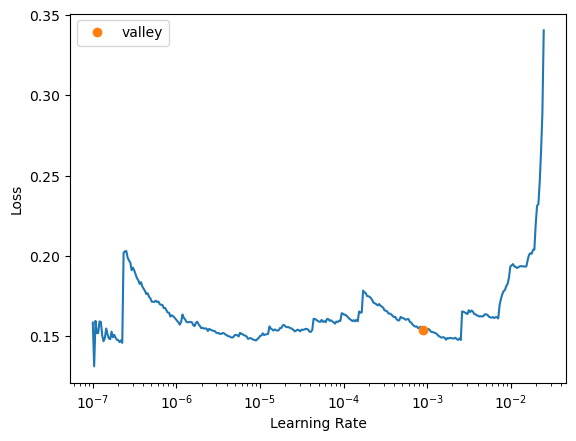

In [63]:
learn.lr_find(num_it=500)

In [55]:
learn.fit(2, 3e-3)
learn.fit_flat_cos(5, 7e-4, pct_start=0.7)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.122136,0.125724,0.181493,0.313605,0.673079,34:19
1,0.121282,0.119819,0.176421,0.294398,0.690070,34:14


Better model found at epoch 0 with r_squared value: 0.6730790734291077.
Better model found at epoch 1 with r_squared value: 0.6900703310966492.


epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.109932,0.109887,0.160886,0.268899,0.718790,34:21
1,0.107647,0.109236,0.159493,0.265550,0.721290,34:24
2,0.104061,0.108931,0.159251,0.263329,0.722589,34:21
3,0.104492,0.109865,0.159870,0.265500,0.720093,34:23
4,0.098991,0.110590,0.160912,0.265195,0.718406,34:20
5,0.098965,0.111460,0.161282,0.267053,0.716199,34:20
6,0.093325,0.111975,0.160589,0.268610,0.714019,34:24
7,0.091725,0.112911,0.161246,0.269824,0.712248,34:24
8,0.090569,0.113749,0.161335,0.271304,0.709899,34:26
9,0.087785,0.114089,0.160870,0.271594,0.708751,34:21


Better model found at epoch 0 with r_squared value: 0.7187901735305786.
Better model found at epoch 1 with r_squared value: 0.7212895750999451.
Better model found at epoch 2 with r_squared value: 0.7225892543792725.


KeyboardInterrupt: 

learn.fit(2, 3e-3)
learn.fit_flat_cos(15, 7e-4, pct_start=0.7)

In [61]:
learn.load('model')

/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [63]:
learn.validate()

IndexError: Exception occured in `SaveModelCallback` when calling event `after_epoch`:
	list index out of range

In [ ]:
learn.fit_flat_cos(5, 1e-4, pct_start=0.5)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.084216,0.111724,0.161324,0.263525,0.715918,32:01


Better model found at epoch 0 with r_squared value: 0.7159183621406555.


In [33]:
learn.validate()

(#4) [0.11172444373369217,0.16132423281669617,0.26352497935295105,0.7159183621406555]

In [34]:
learn.fit_flat_cos(10, 1e-3, pct_start=0.5)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.129519,0.130109,0.191536,0.325054,0.660586,32:39
1,0.124522,0.122357,0.183700,0.302771,0.683851,32:04
2,0.116473,0.117733,0.175865,0.292754,0.695318,32:01
3,0.111453,0.117234,0.175316,0.289118,0.696406,31:59
4,0.112941,0.114254,0.171726,0.278642,0.706919,32:04
5,0.108034,0.113473,0.169836,0.274081,0.710151,32:05
6,0.107722,0.113605,0.170169,0.272091,0.710448,32:04
7,0.092441,0.111157,0.163690,0.263591,0.717383,32:01
8,0.087232,0.110955,0.160811,0.261027,0.718037,32:00
9,0.078567,0.112318,0.160453,0.264056,0.714334,32:02


Better model found at epoch 0 with r_squared value: 0.6605860590934753.
Better model found at epoch 1 with r_squared value: 0.6838511228561401.
Better model found at epoch 2 with r_squared value: 0.6953175067901611.
Better model found at epoch 3 with r_squared value: 0.6964060664176941.
Better model found at epoch 4 with r_squared value: 0.7069191932678223.
Better model found at epoch 5 with r_squared value: 0.7101508975028992.
Better model found at epoch 6 with r_squared value: 0.7104479074478149.
Better model found at epoch 7 with r_squared value: 0.7173829078674316.
Better model found at epoch 8 with r_squared value: 0.7180368900299072.


Process ForkProcess-14:
Process ForkProcess-29:
Process ForkProcess-7:
Process ForkProcess-5:
Process ForkProcess-4:
Process ForkProcess-18:
Process ForkProcess-26:
Process ForkProcess-6:
Process ForkProcess-9:
Process ForkProcess-2:
Process ForkProcess-25:
Process ForkProcess-13:
Process ForkProcess-28:
Process ForkProcess-31:
Process ForkProcess-17:
Process ForkProcess-3:
Process ForkProcess-1:
Process ForkProcess-19:
Process ForkProcess-30:
Process ForkProcess-21:
Process ForkProcess-8:
Process ForkProcess-27:
Process ForkProcess-16:
Process ForkProcess-20:
Process ForkProcess-24:
Process ForkProcess-15:
Process ForkProcess-22:
Process ForkProcess-23:
Process ForkProcess-32:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last)

In [ ]:
learn.fit_flat_cos(15, 8e-4, pct_start=0.5)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.131708,0.135052,0.186262,0.365141,0.636121,30:41
1,0.123678,0.126473,0.182601,0.318880,0.669278,30:19
2,0.119831,0.120116,0.172366,0.304067,0.686703,30:22


Better model found at epoch 0 with r_squared value: 0.6361209154129028.
Better model found at epoch 1 with r_squared value: 0.6692783236503601.
Better model found at epoch 2 with r_squared value: 0.6867033243179321.


In [52]:
learn.save('mwt_v1')

Path('models/mwt_v1.pth')

In [ ]:
165/(198*1e4)

In [88]:
learn.fit_flat_cos(15, 4e-4, pct_start=0.5)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.229272,0.260041,0.152555,0.260041,0.727625,27:52
1,0.210327,0.256274,0.153173,0.256274,0.729453,27:53
2,0.210848,0.252755,0.153384,0.252755,0.729167,27:57
3,0.369781,0.252151,0.153907,0.252151,0.728009,27:55
4,0.190333,0.252129,0.154275,0.252129,0.725401,27:54
5,0.194347,0.253543,0.154800,0.253543,0.723863,27:55
6,0.188494,0.256584,0.155276,0.256584,0.719586,27:55
7,0.184154,0.256038,0.155658,0.256038,0.719379,27:54
8,0.178666,0.258872,0.156046,0.258872,0.715114,27:56
9,0.168267,0.257935,0.155296,0.257935,0.716201,27:51


Better model found at epoch 0 with valid_loss value: 0.2600410580635071.
Better model found at epoch 1 with valid_loss value: 0.25627413392066956.
Better model found at epoch 2 with valid_loss value: 0.2527551054954529.
Better model found at epoch 3 with valid_loss value: 0.2521514594554901.
Better model found at epoch 4 with valid_loss value: 0.2521290183067322.


In [73]:
learn.fit_flat_cos(20, 8e-4, pct_start=0.5)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.221799,0.248883,0.161289,0.248883,0.624436,19:30
1,0.216447,0.249240,0.160901,0.249240,0.621538,19:30
2,0.211245,0.249448,0.160596,0.249448,0.617848,19:31
3,0.221787,0.248711,0.160692,0.248711,0.620983,19:34
4,0.214866,0.249098,0.160391,0.249098,0.619240,19:35
5,0.212531,0.249636,0.160608,0.249636,0.621107,19:35
6,0.210268,0.251274,0.160549,0.251274,0.621262,19:36
7,0.205438,0.249965,0.160234,0.249965,0.612630,19:33
8,0.211535,0.251200,0.160285,0.251200,0.616812,19:34
9,0.202592,0.250676,0.160388,0.250676,0.620815,19:33


Better model found at epoch 0 with valid_loss value: 0.24888284504413605.
Better model found at epoch 3 with valid_loss value: 0.24871104955673218.


In [74]:
learn.save('good_v3')

Path('models/good_v3.pth')

In [71]:
learn.fit_flat_cos(10, 1e-4, pct_start=0.5)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.232228,0.257023,0.163198,0.257023,0.605320,19:34
1,0.241770,0.252950,0.162589,0.252950,0.616660,19:35
2,0.219839,0.249665,0.161875,0.249665,0.611379,19:35
3,0.225076,0.249045,0.161634,0.249045,0.616109,19:35
4,0.211528,0.249282,0.161465,0.249282,0.613677,19:35
5,0.217431,0.248704,0.160870,0.248704,0.610308,19:36
6,0.300959,0.248664,0.160695,0.248664,0.615366,19:36
7,0.219857,0.248102,0.160497,0.248102,0.617658,19:37
8,0.224552,0.248065,0.160396,0.248065,0.619523,19:36
9,0.213481,0.248097,0.160325,0.248097,0.618928,19:36


Better model found at epoch 0 with valid_loss value: 0.2570227384567261.
Better model found at epoch 1 with valid_loss value: 0.2529500126838684.
Better model found at epoch 2 with valid_loss value: 0.2496650665998459.
Better model found at epoch 3 with valid_loss value: 0.24904529750347137.
Better model found at epoch 5 with valid_loss value: 0.24870361387729645.
Better model found at epoch 6 with valid_loss value: 0.2486642599105835.
Better model found at epoch 7 with valid_loss value: 0.248102068901062.
Better model found at epoch 8 with valid_loss value: 0.24806547164916992.


In [38]:
torch.save(net.state_dict(), 'model_weights_good_v1.pth')

In [34]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.505111813545227.


(#4) [1.6002970933914185,0.505111813545227,1.6571693420410156,0.21333633206727462]

In [ ]:
learn.fit_flat_cos(20, 1e-3)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.326428,0.325009,0.234470,0.355308,0.493184,25:55
1,0.266216,0.291889,0.213740,0.315320,0.501836,26:59
2,0.262931,0.283098,0.208533,0.304048,0.549058,27:01
3,0.256095,0.275646,0.202871,0.295436,0.575205,27:07


[2024-04-25 23:31:58,521] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (64)
   function: 'forward' (/tmp/ipykernel_23299/3148654658.py:112)
   reasons:  ___check_obj_id(self, 140033784157216)
to diagnose recompilation issues, see https://pytorch.org/docs/master/dynamo/troubleshooting.html.


Better model found at epoch 0 with valid_loss value: 0.32500866055488586.


[2024-04-25 23:32:20,991] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (64)
   function: 'forward' (/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torchvision/ops/misc.py:319)
   reasons:  ___check_obj_id(self, 140033784156448)
to diagnose recompilation issues, see https://pytorch.org/docs/master/dynamo/troubleshooting.html.


Better model found at epoch 1 with valid_loss value: 0.2918890714645386.
Better model found at epoch 2 with valid_loss value: 0.28309792280197144.
Better model found at epoch 3 with valid_loss value: 0.2756464183330536.


In [56]:
learn.fit_flat_cos(6, 1e-3)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.164413,0.165433,0.177333,0.341697,0.417671,07:32
1,0.157905,0.160126,0.169911,0.326655,0.454772,07:15
2,0.156040,0.157170,0.166138,0.316997,0.479607,07:15
3,0.157877,0.155061,0.163412,0.310182,0.490179,07:16
4,0.153847,0.151915,0.159921,0.296685,0.539397,07:16
5,0.145465,0.145779,0.153717,0.277628,0.580840,07:15


In [82]:
learn.fit_flat_cos(6, 7e-3)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.196049,0.195223,0.172460,0.320301,0.470430,07:29


In [43]:
learn.save('unet_v3_big')

Path('models/unet_v3_big.pth')

In [81]:
learn.fit_flat_cos(5, 3e-3)

epoch,train_loss,valid_loss,mae,mse,r_squared,time


KeyboardInterrupt: 

In [66]:
test_df = pl.read_parquet('/mnt/ssd/kaggle/test.parquet')

In [70]:
#test_df = pl.read_csv('/mnt/ssd/kaggle/test.csv')
test_df = pl.read_parquet('/mnt/ssd/kaggle/test.parquet')
x_test = test_df.select(FEAT_COLS).to_numpy()

test_ds = Loader({'x' : x_test, 'emb' : np.zeros(x_test.shape[0], dtype=int)}, {'x' : norm_x})
test_loader = fv.DataLoader(test_ds, batch_size=bs, drop_last=False, shuffle=False, 
                            num_workers=0, pin_memory=True)

In [71]:
test_df

sample_id,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,state_t_9,state_t_10,state_t_11,state_t_12,state_t_13,state_t_14,state_t_15,state_t_16,state_t_17,state_t_18,state_t_19,state_t_20,state_t_21,state_t_22,state_t_23,state_t_24,state_t_25,state_t_26,state_t_27,state_t_28,state_t_29,state_t_30,state_t_31,state_t_32,state_t_33,state_t_34,state_t_35,state_t_36,state_t_37,state_t_38,state_t_39,state_t_40,state_t_41,state_t_42,state_t_43,state_t_44,state_t_45,state_t_46,state_t_47,state_t_48,state_t_49,state_t_50,state_t_51,state_t_52,state_t_53,state_t_54,state_t_55,state_t_56,state_t_57,state_t_58,state_t_59,state_q0001_0,state_q0001_1,state_q0001_2,state_q0001_3,state_q0001_4,state_q0001_5,state_q0001_6,state_q0001_7,state_q0001_8,state_q0001_9,state_q0001_10,state_q0001_11,state_q0001_12,state_q0001_13,state_q0001_14,state_q0001_15,state_q0001_16,state_q0001_17,state_q0001_18,state_q0001_19,state_q0001_20,state_q0001_21,state_q0001_22,state_q0001_23,state_q0001_24,state_q0001_25,state_q0001_26,state_q0001_27,state_q0001_28,state_q0001_29,state_q0001_30,state_q0001_31,state_q0001_32,state_q0001_33,state_q0001_34,state_q0001_35,state_q0001_36,state_q0001_37,state_q0001_38,state_q0001_39,state_q0001_40,state_q0001_41,state_q0001_42,state_q0001_43,state_q0001_44,state_q0001_45,state_q0001_46,state_q0001_47,state_q0001_48,state_q0001_49,state_q0001_50,state_q0001_51,state_q0001_52,state_q0001_53,state_q0001_54,state_q0001_55,state_q0001_56,state_q0001_57,state_q0001_58,state_q0001_59,state_q0002_0,state_q0002_1,state_q0002_2,state_q0002_3,state_q0002_4,state_q0002_5,state_q0002_6,state_q0002_7,state_q0002_8,state_q0002_9,state_q0002_10,state_q0002_11,state_q0002_12,state_q0002_13,state_q0002_14,state_q0002_15,state_q0002_16,state_q0002_17,state_q0002_18,state_q0002_19,state_q0002_20,state_q0002_21,state_q0002_22,state_q0002_23,state_q0002_24,state_q0002_25,state_q0002_26,state_q0002_27,state_q0002_28,state_q0002_29,state_q0002_30,state_q0002_31,state_q0002_32,state_q0002_33,state_q0002_34,state_q0002_35,state_q0002_36,state_q0002_37,state_q0002_38,state_q0002_39,state_q0002_40,state_q0002_41,state_q0002_42,state_q0002_43,state_q0002_44,state_q0002_45,state_q0002_46,state_q0002_47,state_q0002_48,state_q0002_49,state_q0002_50,state_q0002_51,state_q0002_52,state_q0002_53,state_q0002_54,state_q0002_55,state_q0002_56,state_q0002_57,state_q0002_58,state_q0002_59,state_q0003_0,state_q0003_1,state_q0003_2,state_q0003_3,state_q0003_4,state_q0003_5,state_q0003_6,state_q0003_7,state_q0003_8,state_q0003_9,state_q0003_10,state_q0003_11,state_q0003_12,state_q0003_13,state_q0003_14,state_q0003_15,state_q0003_16,state_q0003_17,state_q0003_18,state_q0003_19,state_q0003_20,state_q0003_21,state_q0003_22,state_q0003_23,state_q0003_24,state_q0003_25,state_q0003_26,state_q0003_27,state_q0003_28,state_q0003_29,state_q0003_30,state_q0003_31,state_q0003_32,state_q0003_33,state_q0003_34,state_q0003_35,state_q0003_36,state_q0003_37,state_q0003_38,state_q0003_39,state_q0003_40,state_q0003_41,state_q0003_42,state_q0003_43,state_q0003_44,state_q0003_45,state_q0003_46,state_q0003_47,state_q0003_48,state_q0003_49,state_q0003_50,state_q0003_51,state_q0003_52,state_q0003_53,state_q0003_54,state_q0003_55,state_q0003_56,state_q0003_57,state_q0003_58,state_q0003_59,state_u_0,state_u_1,state_u_2,state_u_3,state_u_4,state_u_5,state_u_6,state_u_7,state_u_8,state_u_9,state_u_10,state_u_11,state_u_12,state_u_13,state_u_14,state_u_15,state_u_16,state_u_17,state_u_18,state_u_19,state_u_20,state_u_21,state_u_22,state_u_23,state_u_24,state_u_25,state_u_26,state_u_27,state_u_28,state_u_29,state_u_30,state_u_31,state_u_32,state_u_33,state_u_34,state_u_35,state_u_36,state_u_37,state_u_38,state_u_39,state_u_40,state_u_41,state_u_42,state_u_43,state_u_44,state_u_45,state_u_46,state_u_47,state_u_48,state_u_49,state_u_50,state_u_51,state_u_52,state_u_53,state_u_54,state_u_55,state_u_56,state_u_57,state_u_58,state_u_59,state_v_0,state_v_1,

In [47]:
import matplotlib.pyplot as plt

plt.plot(batch[0].std(dim=0).numpy())

NameError: name 'batch' is not defined

In [137]:
x_train[:, 180].mean()

4.9721663e-13

In [138]:
x_test[:, 180].mean()

1.8331273364701616e-11

In [1]:
model = torch.compiler.disable(learn.model.eval(),)

NameError: name 'torch' is not defined

In [72]:
model = learn.model.eval()

In [69]:
preds = learn.get_preds(None, dl=test_loader, with_targs=False)

/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torch/nn/modules/loss.py:999: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 368])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


AssertionError: Exception occured in `Recorder` when calling event `after_batch`:
	==:
23552
64

In [74]:
import tqdm
predictions = []

with torch.no_grad():
    for batch in tqdm.tqdm(test_loader):
        x = (batch[0][0].cuda().type(torch.float), batch[0][1].cuda())
        pred = model(x)
        #pred = learn.get_preds
        #pred = norm_y.denorm(pred)
        predictions.append(pred)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9766/9766 [12:01<00:00, 13.53it/s]


In [91]:
batch[0]

[tensor([[-0.2091, -1.1206, -1.5577,  ...,  0.0000,  0.0000,  0.0000],
         [-0.3850, -1.2824, -1.5098,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.1913, -0.1536, -1.0023,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.5073,  0.5929, -0.0575,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.4168, -0.2640, -0.8508,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.3559, -0.1311, -0.6344,  ...,  0.0000,  0.0000,  0.0000]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

In [68]:
x.device

device(type='cuda', index=0)

In [65]:
x.shape

torch.Size([128, 376])

In [128]:
predicts = np.concatenate([pred.cpu() for pred in predictions], axis=0)# * weights[None, :]

In [130]:
predicts = predicts.astype(np.float32)

In [131]:
torch.save(predicts, 'preds6.pt')

In [117]:
#predicts = torch.load('preds.pt')

In [132]:
output = pl.DataFrame(test_df['sample_id'])

In [133]:
output

sample_id
str
"""test_169651"""
"""test_524862"""
"""test_634129"""
"""test_403572"""
"""test_484578"""
…
"""test_578220"""
"""test_395695"""
"""test_88942"""


In [134]:
indx = TARGET_COLS.index('ptend_q0002_26')
col = "ptend_q0002_26"
norm_y.zero_mask[indx] = True

In [135]:
for n, col in enumerate(TARGET_COLS):
    if norm_y.zero_mask[n]:
        print(f'skipping {col}')
        pl_col = pl.lit(0.0, dtype=pl.Float32).alias(col)
    else:
        pl_col = pl.Series(col, predicts[:, n],  dtype=pl.Float32)
    
    output = output.with_columns(pl_col)
        

skipping ptend_q0001_0
skipping ptend_q0001_1
skipping ptend_q0001_2
skipping ptend_q0001_3
skipping ptend_q0001_4
skipping ptend_q0001_5
skipping ptend_q0001_6
skipping ptend_q0001_7
skipping ptend_q0001_8
skipping ptend_q0001_9
skipping ptend_q0001_10
skipping ptend_q0001_11
skipping ptend_q0002_0
skipping ptend_q0002_1
skipping ptend_q0002_2
skipping ptend_q0002_3
skipping ptend_q0002_4
skipping ptend_q0002_5
skipping ptend_q0002_6
skipping ptend_q0002_7
skipping ptend_q0002_8
skipping ptend_q0002_9
skipping ptend_q0002_10
skipping ptend_q0002_11
skipping ptend_q0002_12
skipping ptend_q0002_13
skipping ptend_q0002_14
skipping ptend_q0002_15
skipping ptend_q0002_16
skipping ptend_q0002_17
skipping ptend_q0002_18
skipping ptend_q0002_19
skipping ptend_q0002_20
skipping ptend_q0002_21
skipping ptend_q0002_22
skipping ptend_q0002_23
skipping ptend_q0002_24
skipping ptend_q0002_25
skipping ptend_q0002_26
skipping ptend_q0003_0
skipping ptend_q0003_1
skipping ptend_q0003_2
skipping ptend_

In [136]:
output.write_csv('submission.csv', )

In [123]:
weights

array([3.09812656e+04, 2.25024316e+04, 1.88941465e+04, 1.45142451e+04,
       1.09443477e+04, 9.06501074e+03, 9.66366895e+03, 1.26885576e+04,
       1.98901719e+04, 2.58313730e+04, 3.38903672e+04, 4.41229414e+04,
       5.98112578e+04, 7.94340781e+04, 1.07358812e+05, 1.35720844e+05,
       1.49399844e+05, 1.28492953e+05, 9.17462344e+04, 7.27487656e+04,
       6.65315391e+04, 6.29323047e+04, 5.66102695e+04, 4.94731445e+04,
       4.30291836e+04, 3.69126758e+04, 3.14869316e+04, 2.68980723e+04,
       2.33166387e+04, 2.04597305e+04, 1.83856836e+04, 1.71114043e+04,
       1.63378096e+04, 1.58577598e+04, 1.55809023e+04, 1.54975908e+04,
       1.56122559e+04, 1.57978848e+04, 1.59742188e+04, 1.61303955e+04,
       1.62613105e+04, 1.63718926e+04, 1.63970195e+04, 1.63254639e+04,
       1.62286406e+04, 1.61918096e+04, 1.63412080e+04, 1.66457109e+04,
       1.70054941e+04, 1.74302988e+04, 1.79072402e+04, 1.84315527e+04,
       1.90324707e+04, 1.97013555e+04, 2.04082363e+04, 2.09672070e+04,
      

In [124]:
gc.collect()

NameError: name 'gc' is not defined

In [53]:
preds, targets = learn.get_preds()

In [140]:
for n, col in enumerate(TARGET_COLS):
    r = mse(preds[:, n:n+1], targets[:, n:n+1])
    print(f'{col} : {r}')

ptend_t_0 : 0.01796277053654194
ptend_t_1 : 0.01580028049647808
ptend_t_2 : 0.005049095023423433
ptend_t_3 : 0.0012899171561002731
ptend_t_4 : 0.0006612258148379624
ptend_t_5 : 0.000465095741674304
ptend_t_6 : 0.00043876576819457114
ptend_t_7 : 0.0007029272383078933
ptend_t_8 : 0.0008303220965899527
ptend_t_9 : 0.0010582703398540616
ptend_t_10 : 0.0018357549561187625
ptend_t_11 : 0.0019260403933003545
ptend_t_12 : 0.002866466762498021
ptend_t_13 : 0.003381755668669939
ptend_t_14 : 0.006356712430715561
ptend_t_15 : 0.01387377455830574
ptend_t_16 : 0.1253134310245514
ptend_t_17 : 0.3069222569465637
ptend_t_18 : 0.533825159072876
ptend_t_19 : 0.5077593922615051
ptend_t_20 : 0.4755598306655884
ptend_t_21 : 0.44834259152412415
ptend_t_22 : 0.3704204261302948
ptend_t_23 : 0.301801860332489
ptend_t_24 : 0.26321732997894287
ptend_t_25 : 0.2153325378894806
ptend_t_26 : 0.17556500434875488
ptend_t_27 : 0.14571933448314667
ptend_t_28 : 0.12255648523569107
ptend_t_29 : 0.10464970022439957
ptend_t_

In [59]:
r_squared(preds, targets)#, mask=~norm_y.zero_mask)

tensor(0.7032)

In [139]:
targets

tensor([[-0.3763, -1.1669, -0.4884,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1509, -1.2552, -1.0004,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3688,  0.5166,  0.1309,  ...,  0.0021,  0.1160,  0.0994],
        ...,
        [ 0.2467,  0.1420, -0.0272,  ...,  0.0320,  0.2035,  0.2017],
        [ 1.3127, -0.3512,  1.1094,  ...,  1.6892,  0.9116,  0.2239],
        [-0.6008, -0.4522, -0.5116,  ...,  0.0000,  0.0000,  0.0000]])